# モデルの学習曲線（特徴量エンジニアリング）

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime
import os
import pathlib

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as mdates
from scipy.interpolate import make_smoothing_spline

from funcs.ios import get_excel_sheet
from funcs.tse import get_ticker_name_list

In [3]:
# ソースファイル
date_str = "20250819"
path_excel = f"../excel/tick_{date_str}.xlsx"
code = "7011"
name = get_ticker_name_list([code])[code]
print(code, name)
excel_file = str(pathlib.Path(path_excel).resolve())
df_tick = get_excel_sheet(excel_file, code)
df_tick.index = [
    pd.to_datetime(str(datetime.datetime.fromtimestamp(t))) for t in df_tick["Time"]
]
print(df_tick.head())

7011 三菱重工業
                                    Time  Price   Volume
2025-08-19 09:01:15.496406  1.755562e+09   4025  1213700
2025-08-19 09:01:17.326403  1.755562e+09   4030  1827900
2025-08-19 09:01:17.515900  1.755562e+09   4030  1827900
2025-08-19 09:01:18.532149  1.755562e+09   4030  1827900
2025-08-19 09:01:19.536610  1.755562e+09   4033  1888700


## ティックデータ

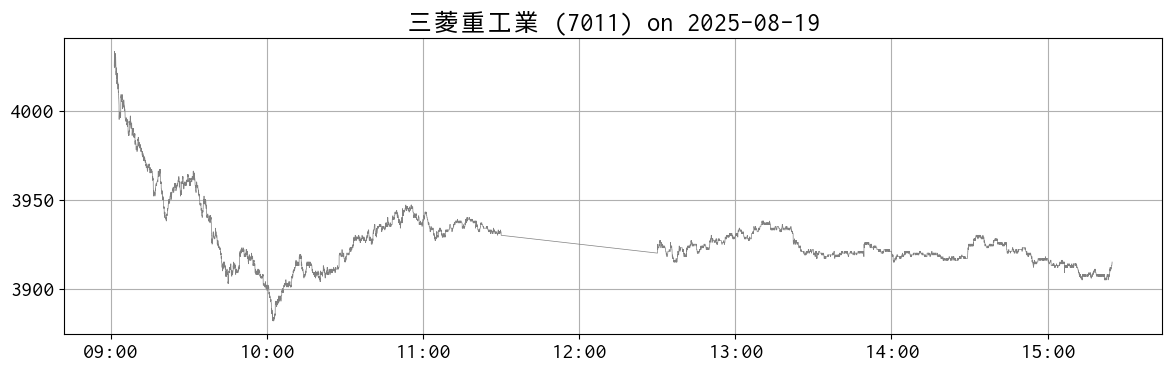

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df_tick["Price"], color="gray", linewidth=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.grid()

ax.set_title(f"{name} ({code}) on {df_tick.index[0].strftime('%Y-%m-%d')}")

plt.tight_layout()
#plt.savefig(f"screenshots/tick_{code}_{date_str}.png")
plt.show()

## 学習曲線

In [5]:
path_csv = "data/training_history_7011_20250819_20250920_1.csv"
csv_file = str(pathlib.Path(path_csv).resolve())
df_csv = pd.read_csv(csv_file)
df_csv

,epoch,episode_reward,pnl_total,approx_kl,clipfrac,transactions
0,1,-374.67942,-19.0,0.021027,0.281306,6262
1,2,-242.13112,25.0,0.005325,0.240382,7064
2,3,-272.28330,54.0,0.006395,0.200696,6799
3,4,-212.63247,45.0,0.006044,0.203727,7092
4,5,-299.88394,23.0,0.005890,0.206115,6916
...,...,...,...,...,...,...
195,196,-101.53086,91.0,0.001461,0.153370,6861
196,197,-305.33288,-21.0,0.001709,0.116915,6763
197,198,-300.03294,-26.0,0.000839,0.163141,6895
198,199,-256.58111,34.0,0.001834,0.148634,6879


In [6]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 10

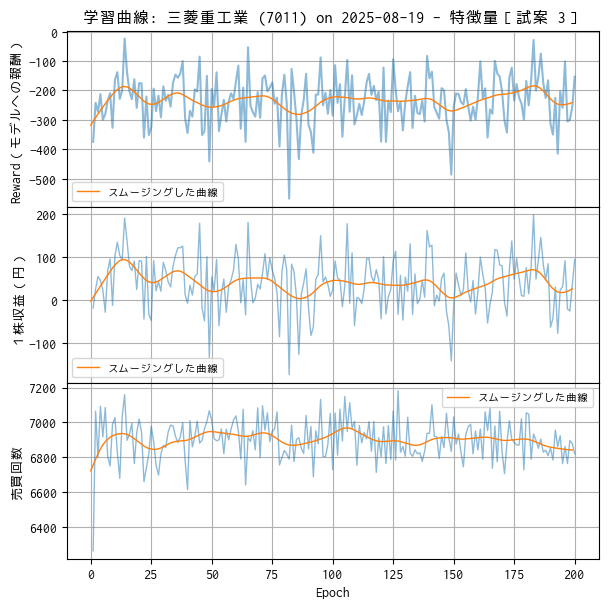

In [14]:
ax = dict()
n = 3

if n > 1:
    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(
        n,
        1,
        wspace=0.0,
        hspace=0.0,
    )
    for i, axis in enumerate(gs.subplots(sharex="col")):
        ax[i] = axis
else:
    fig, ax[0] = plt.subplots(figsize=(12, 4))

xs = np.linspace(0, len(df_csv) - 1, 200)

ax[0].set_title(f"学習曲線: {name} ({code}) on {df_tick.index[0].strftime('%Y-%m-%d')} - 特徴量［試案 3］")
ax[0].plot(df_csv["epoch"], df_csv["episode_reward"], alpha=0.5)
spl = make_smoothing_spline(df_csv["epoch"], df_csv["episode_reward"])
ax[0].plot(xs, spl(xs), linewidth=1, label="スムージングした曲線")
ax[0].grid()
ax[0].set_ylabel("Reward（モデルへの報酬）")
ax[0].legend(fontsize=8)

ax[1].plot(df_csv["epoch"], df_csv["pnl_total"], linewidth=1, alpha=0.5)
spl = make_smoothing_spline(df_csv["epoch"], df_csv["pnl_total"])
ax[1].plot(xs, spl(xs), linewidth=1, label="スムージングした曲線")
ax[1].grid()

ax[1].set_ylabel("１株収益（円）")
ax[1].legend(fontsize=8)

ax[2].plot(df_csv["epoch"], df_csv["transactions"], linewidth=1, alpha=0.5)
spl = make_smoothing_spline(df_csv["epoch"], df_csv["transactions"])
ax[2].plot(xs, spl(xs), linewidth=1, label="スムージングした曲線")
ax[2].grid()

ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("売買回数")
ax[2].legend(fontsize=8)

plt.tight_layout(pad=0.4, rect=[0, 0, 1.0, 1.0])
plt.savefig(f"screenshots/learning_curve_{code}_{date_str}_20250920_1.png")
plt.show()